<a href="https://colab.research.google.com/github/alixintong/btt-ai-know-your-customer/blob/han/binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this cell allows access to our folder

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# cell for imports - add as needed
import torch 
import cv2
import numpy as np 
import pandas as pd
import os, os.path
from fastai.vision.all import *

### Generate additional images that do not contain documents

In [ ]:
# print the dimension of an output frame
# img = cv2.imread('datasheet001_frames/datasheet001_frames_00214.jpg')
# dimensions = img.shape
# print(dimensions)

In [ ]:
# use RandomCrop() in fastai
# img1 = img.RandomCrop((1080,1920,3))


2nd attempt: The fast ai random crop is not the best tool to use...In this section, Im going to try to "crop" in for loop using the Pillow Image Library. 



In [ ]:
from PIL import Image
import PIL 
import cv2
import re

In [ ]:
url='https://drive.google.com/file/d/1qh5N-hOVmWtcb5mEBB7mlh4AsdxbQfOA/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,_rejected
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,False
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,False
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,False
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,False
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,False


In [ ]:
print("top-left:", df['point/1/_x'][0], df['point/1/_y'][0])
print("bottom-right:", df['point/3/_x'][0], df['point/3/_y'][0])

top-left: 737.377 201.383
bottom-right: 1259.02 791.942


In [ ]:
#before adding the cropped image in...
# I need to change directories using OS.
# Without doing this, it will result in an error.

#using previous implementation 

# create frames for datasheet001_frames first
#directory1 = os.path.join(root_path, 'datasets', 'sampleDataset', 'input_sample', 'background00')
os.chdir('/content/drive/MyDrive/AI_studio_Fall22/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/')
print(os.getcwd())



In [ ]:
# Note: (image size: 1920 x 1080 pixels)
# The crop function takes in: ((top-left, bottom-right))

In [ ]:
ds_img_number = 1 
while ds_img_number <= 214:
  number = ("%05d" % ds_img_number)
  img_str = ("datasheet001_frames/datasheet001_frames_%s.jpg" % (number))
  img = Image.open(img_str)
  img2 = img.crop((0, 0,  df['point/0/_x'][ds_img_number-1], df['point/0/_y'][ds_img_number-1])) #subtracting 1 because the cvs table starts at 0 
  img2.save(("/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames_no_doc/Datasheet001_frames_no_doc_%s.jpg")% (number))
  ds_img_number+=1


### Build a model to classify images into documents & non-documents.

In [ ]:
import re

In [ ]:
# use datasheet001 as csv instead of xml
# using Han's XML with the manually values into the groundtruth
url='https://drive.google.com/file/d/17CcTQHts6U_L4YUgsyEfTao974K8ioWu/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,_rejected
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,False
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,False
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,False
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,False
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,False


In [ ]:
# save _rejected column for binary classification

path = '/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames'

files = get_image_files(path + "/datasheet001_combined")

df["document"] = df["_rejected"].apply(lambda x: not x) 
bin_doc = df['document']
df = df.drop('_rejected', axis = 1)

df.head()

,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,document
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,True
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,True
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,True
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,True
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,True


In [ ]:
files[0],files[214],files[427]

(Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_combined/datasheet001_frames_00026.jpg'),
 Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_combined/Datasheet001_frames_no_doc_00001.jpg'),
 Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_combined/Datasheet001_frames_no_doc_00214.jpg'))

In [ ]:
bin_doc.tail()

423    False
424    False
425    False
426    False
427    False
Name: document, dtype: bool

In [ ]:
bin_doc.head()

0    True
1    True
2    True
3    True
4    True
Name: document, dtype: bool

In [ ]:
# label function
# def label_func(f):
#   frame_num = f.split('.jpg')[0]
#   frame_num = int(re.findall('[1-9]+', f)[1])
#   rowNum = frame_num-1
#   return bin_doc.loc[rowNum]

In [ ]:
'''
The new labeling: 
The photos are labeled with: 
- lowercase has documents (document = True) 
- Uppercase contains NO documents (document = False)
'''

def label_func(f):
  return f[0].islower()


In [ ]:
# DataLoader object
# Stuck on: 'KeyError: '00163''
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

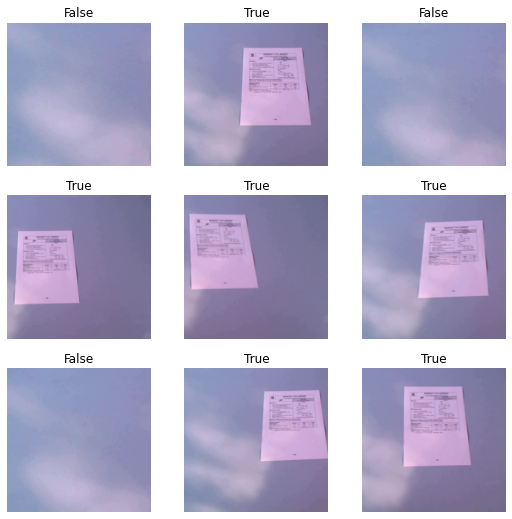

In [ ]:
dls.show_batch()

In [ ]:
# Create Learner with pretrained ResNet34
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.573977,0.064204,0.023529,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.000360,0.000079,0.000000,00:11


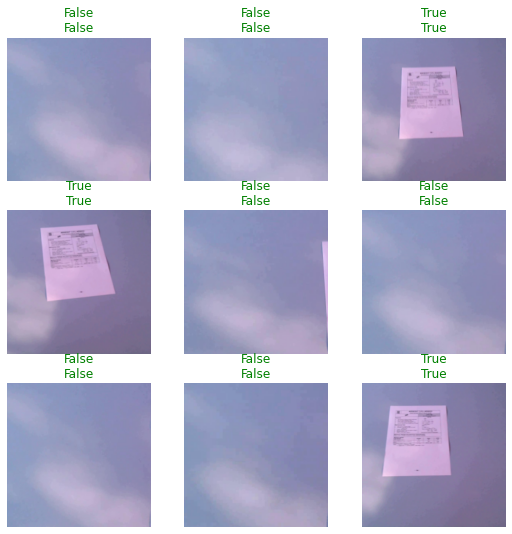

In [ ]:
learn.show_results()